In [3]:
from datasets import load_dataset

/Users/shilongcui/shilongjaycui/emotion-classifier/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset = load_dataset('emotion')

/Users/shilongcui/shilongjaycui/emotion-classifier/venv/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [5]:
import pandas as pd

pd.set_option('display.max_colwidth', None)  # Show full column width

In [6]:
from pandas import DataFrame

train_dataset = dataset['train']
train_df: DataFrame = dataset["train"].to_pandas()
train_df.sample(n=5)

,text,label
936,i was feeling creative i see you alternate version of me,1
2398,i guess im sad because i feel alone in this,0
2726,sometime back another girl who was in terms with my exboyfriend came to shout at me at twelve midnight it was because she thought i was still interested in the boy,3
12276,i just feel distressed i dont know why though but i do,4
10074,i feel so happy today me so,1


In [7]:
from typing import Dict

emotion_dict: Dict[int, str] = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise',
}

train_df_copy = train_df.copy(deep=True)
train_df_copy['emotion'] = train_df_copy['label'].apply(lambda index: emotion_dict[index])
train_df_copy = train_df_copy[['text', 'emotion']]
train_df_copy

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag and i said to anna that i feel like i have been beaten up,sadness
15996,i am now turning and i feel pathetic that i am still waiting tables and subbing with a teaching degree,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and im glad that t,anger


In [8]:
from pandas import Series

X: Series = train_df['text']
y: Series = train_df['label']

print(f'X.shape: {X.shape}')
print(f'X: {X.tolist()[:5]}')

print(f'\ny.shape: {y.shape}')
print(f'y: {y.tolist()[:5]}')

X.shape: (16000,)
X: ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']

y.shape: (16000,)
y: [0, 0, 3, 2, 3]


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

In [10]:
# Creating the pipeline
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

In [11]:
model.fit(X, y)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])

In [12]:
from sklearn.metrics import accuracy_score, classification_report
from typing import List

print(dataset.column_names)

# For a classification task
X_test: List = dataset['test']['text']
y_test: List = dataset['test']['label']

y_pred = model.predict(X=X_test)  # predict the actual class
print("Accuracy:", accuracy_score(y_true=y_test, y_pred=y_pred))
print(classification_report(y_test, y_pred))

{'train': ['text', 'label'], 'validation': ['text', 'label'], 'test': ['text', 'label']}
Accuracy: 0.8655
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       581
           1       0.84      0.94      0.88       695
           2       0.83      0.64      0.72       159
           3       0.89      0.83      0.86       275
           4       0.85      0.86      0.86       224
           5       0.66      0.56      0.61        66

    accuracy                           0.87      2000
   macro avg       0.83      0.79      0.81      2000
weighted avg       0.87      0.87      0.86      2000



Create a precision-recall curve.

In [13]:
# Get predicted probabilities for the positive class
y_scores = model.predict_proba(X=X_test)  # predict the class probabilities
print(f'y_scores:\n{y_scores}\n')
print(f'y_scores.shape: {y_scores.shape}')

y_scores:
[[0.68  0.17  0.01  0.09  0.05  0.   ]
 [0.92  0.05  0.01  0.02  0.    0.   ]
 [0.81  0.11  0.02  0.04  0.01  0.01 ]
 ...
 [0.12  0.72  0.08  0.04  0.04  0.   ]
 [0.2   0.64  0.04  0.06  0.06  0.   ]
 [0.1   0.09  0.01  0.05  0.516 0.234]]

y_scores.shape: (2000, 6)


In [14]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve values
try:
    precision, recall, _ = precision_recall_curve(y_true=y_test, probas_pred=y_scores)
except ValueError:
    print('`precision_recall_curve` is designed for binary classification problems.')
    print('''ChatGPT: While precision-recall curves are commonly associated with binary
          classification problems, they can be extended to multi-class scenarios by
          considering each class as a separate binary classification problem.''')

`precision_recall_curve` is designed for binary classification problems.
ChatGPT: While precision-recall curves are commonly associated with binary
          classification problems, they can be extended to multi-class scenarios by
          considering each class as a separate binary classification problem.


In [15]:
from sklearn.metrics import auc
from numpy import ndarray
import numpy as np

# Compute precision-recall curves for each class
precision_dict: Dict = {}
recall_dict: Dict = {}
average_precision: Dict = {}

# Loop through each class
for i in range(len(model.classes_)):
    # Compute precision-recall curve
    y_test: ndarray = np.array(y_test)
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_test == i, y_scores[:, i])

    # Compute area under the curve (AUC) for precision-recall curve
    average_precision[i] = auc(recall_dict[i], precision_dict[i])

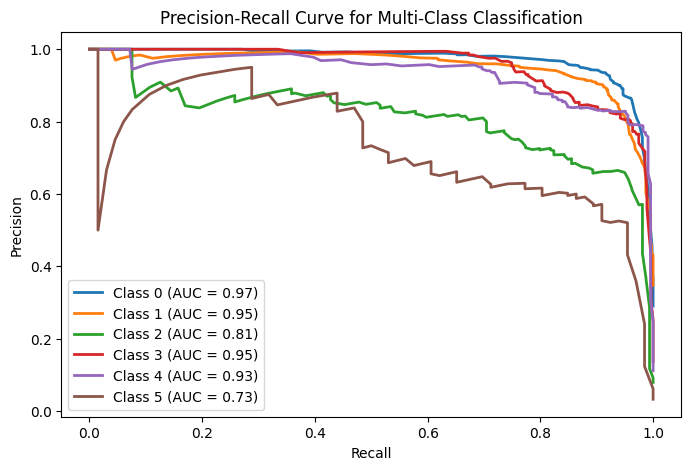

In [16]:
import matplotlib.pyplot as plt

# Plot the precision-recall curves for each class
plt.figure(figsize=(8, 5))
for i in range(len(model.classes_)):
    plt.plot(
        recall_dict[i],
        precision_dict[i],
        lw=2,
        label=f'Class {i} (AUC = {average_precision[i]:.2f})',
    )

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class Classification')
plt.legend(loc='best')
plt.show()

Create a confusion matrix.

In [17]:
from sklearn.metrics import confusion_matrix

conf_matrix: ndarray = confusion_matrix(y_true=y_test, y_pred=y_pred)

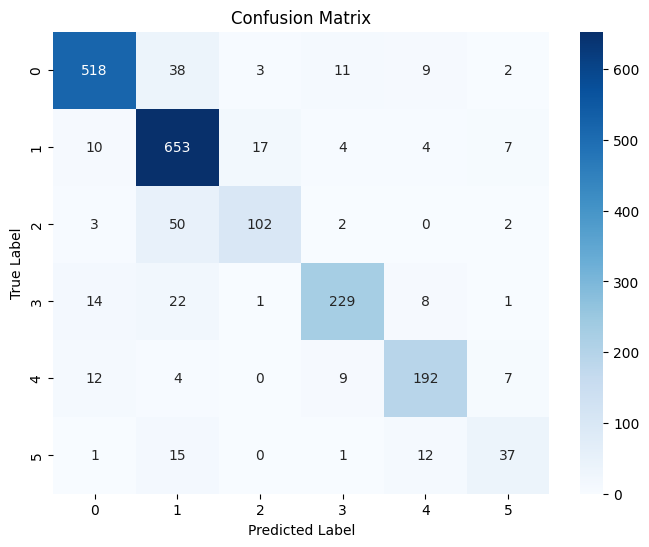

In [18]:
import seaborn as sns

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=model.classes_,
            yticklabels=model.classes_,
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Examine false positives and false negatives.

In [39]:
print(f'# sentences: {len(X_test)}')
print(f'# predicted labels: {len(y_pred)}')
print(f'# actual labels: {len(y_test)}')

test_df: DataFrame = DataFrame({
    'text': X_test,
    'predicted label': y_pred,
    'actual label': y_test,
})
misclassifications = test_df[test_df['predicted label'] != test_df['actual label']]
misclassifications

# sentences: 2000
# predicted labels: 2000
# actual labels: 2000


,text,predicted label,actual label
6,i felt anger when at the end of a telephone call,1,3
10,i don t feel particularly agitated,3,4
36,i feel very honoured to be included in a magzine which prioritises health and clean living so highly im curious do any of you read magazines concerned with health and clean lifestyles such as the green parent,5,1
40,i feel if i completely hated things i d exercise my democratic right speak my mind in what ever ways possible and try to enact a change,0,3
56,i had every intention of doing more gardening this morning while it was still cool but i was just feeling so rotten,1,0
...,...,...,...
1959,i check you when you re sleeping feel your nose and toes to be sure you aren t too hot or cold,3,1
1979,i have no strong feelings for this book neither hated nor loved it,0,3
1983,im thinking well i could be a bit smaller but for health reasons and i should see a doctor more regularly because im feeling crappy,1,0
1986,im feeling scared and the rage filled im mad at me,3,4


In [46]:
print(f'labels: {emotion_dict}')

labels: {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}


false positives:

In [49]:
for encoding in emotion_dict:
    emotion = emotion_dict[encoding]
    false_positives = misclassifications[misclassifications['predicted label'] == encoding]
    print(f'\n# of sentences falsely classified to contain {emotion}: {len(false_positives)}')
    
    sample_size = min(len(false_positives), 3)
    false_positives_sample = false_positives.sample(n=sample_size)

    fp_text = false_positives_sample['text'].to_list()
    fp_predicted_label = false_positives_sample['predicted label'].to_list()
    fp_actual_label = false_positives_sample['actual label'].to_list()
    for i in range(sample_size):
        print(f' - \"{fp_text[i]}\" (predicted emotion: {emotion_dict[fp_predicted_label[i]]}; actual emotion: {emotion_dict[fp_actual_label[i]]})')
    


# of sentences falsely classified to contain sadness: 40
 - "i feel appalled right now" (predicted emotion: sadness; actual emotion: anger)
 - "i love to dance but often feel inhibited by my own body unsure what i am capable of hyper concerned about other people watching me and having opinions on my style or just feeling awkward as if i have no idea what i am supposed to do here" (predicted emotion: sadness; actual emotion: fear)
 - "i actually feel agitated which led to a terrible day yesterday in which i was unable to concentrate on anything and basically piddled the day away" (predicted emotion: sadness; actual emotion: anger)

# of sentences falsely classified to contain joy: 129
 - "i feel and talk like a disadvantaged child and am waiting for half my face to come back to me" (predicted emotion: joy; actual emotion: sadness)
 - "i feel more of numb now" (predicted emotion: joy; actual emotion: sadness)
 - "when i heard the last regulation of the socialist govrenment concerning pe

false negatives:

In [50]:
for encoding in emotion_dict:
    emotion = emotion_dict[encoding]
    false_negatives = misclassifications[misclassifications['actual label'] == encoding]
    print(f'\n# of sentences falsely classified to NOT contain {emotion}: {len(false_negatives)}')
    
    sample_size = min(len(false_negatives), 3)
    false_negatives_sample = false_negatives.sample(n=sample_size)

    fp_text = false_negatives_sample['text'].to_list()
    fp_predicted_label = false_negatives_sample['predicted label'].to_list()
    fp_actual_label = false_negatives_sample['actual label'].to_list()
    for i in range(sample_size):
        print(f' - \"{fp_text[i]}\" (predicted emotion: {emotion_dict[fp_predicted_label[i]]}; actual emotion: {emotion_dict[fp_actual_label[i]]})')
    


# of sentences falsely classified to NOT contain sadness: 63
 - "i reread for comfort the familiarity of a book whose plot i already know is easier to deal with when im feeling stressed than a new to me book with all its unknowns" (predicted emotion: anger; actual emotion: sadness)
 - "ive ever read that explains why i feel this way all the time and reassures me that im not just defective somehow" (predicted emotion: joy; actual emotion: sadness)
 - "im far ahead than the released tankouban that are sold here it just wont be the same anymore and the wait wont be as thrilling but damn me if i even feel slightly remorseful for that" (predicted emotion: joy; actual emotion: sadness)

# of sentences falsely classified to NOT contain joy: 42
 - "i had one of my low carb meal bars for breakfast and was feeling smug when i spotted the left over pies muffins and attractive foods" (predicted emotion: sadness; actual emotion: joy)
 - "i feel like some of you have pains and you cannot imagine be